## Applied - Question 6

This question will further analyze the Wage dataset. 

#### Import block

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model as skl_lm
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
plt.style.use('seaborn-white')

Importing the data

In [2]:
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
df = pd.read_csv(f'{data_path}Wage.csv')

# first split
X = df.age
y = df.wage

# peak
df.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


(a) Cross-validate multiple polynomial regression predicting wage using age.

The plot of MSE vs degree shows that there are significant improvement between increasing
to degree 4. However, there is almost non existence once we crossed that point.

This is similar to the result we get from running ANOVA test in the lab.

Text(0, 0.5, 'MSE')

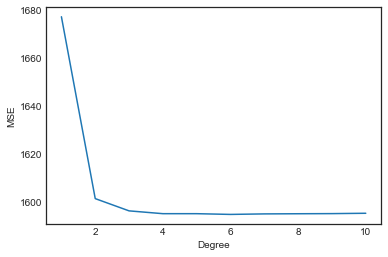

In [3]:
# Set parameters for regressions
p_order = range(1, 11)
kf = KFold(n_splits=10, random_state=1, shuffle=True)
MSE = []
regr = skl_lm.LinearRegression()

# Loop through 10 degree of X and record MSE:
for i in p_order:
    # Transform into i-degree polynomial
    poly = PolynomialFeatures(degree=i)
    X_poly = poly.fit_transform(X.values.reshape(-1,1))
    
    # Cross validation using 10-fold
    score = cross_val_score(regr, X_poly, y, scoring='neg_mean_squared_error',
                            cv=kf).mean()
    MSE.append(-score)

# plot 
plt.plot(p_order, MSE)
plt.xlabel('Degree')
plt.ylabel('MSE')

(0, 333.25527471319606)

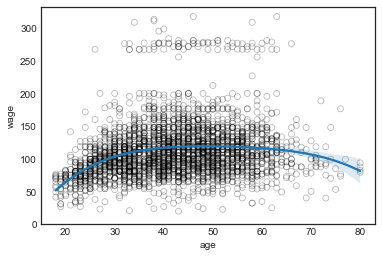

In [4]:
# Fit degree 4 polynomial 
sns.scatterplot(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False)
plt.ylim(ymin=0)

(b) Fit step function to predict wage and age

The CV shows that 8 cuts gives us the best MSE. 

Text(0.5, 1.0, 'MSE vs Cuts')

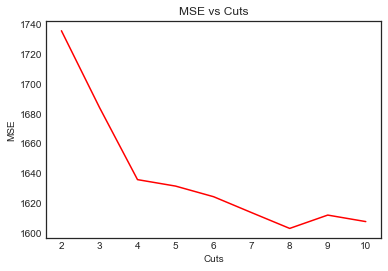

In [5]:
MSE = []
for i in range(2, 11):
    # Cut data into bins of age
    df_cut, bins = pd.cut(df.age, bins=i, retbins=True, right=True)
    
    # Get the step dataframes
    df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age', 'age_cut', 'wage'], axis=1)
    
    # Transform step dataframe into dummies
    df_steps_dummy = pd.get_dummies(df_steps['age_cut'])
    df_steps_dummy.values.reshape(-1,1)
    
    # Calculate MSE with 10-fold
    regr = skl_lm.LinearRegression()
    score = cross_val_score(regr, df_steps_dummy, df_steps.wage, 
                            cv=kf, scoring='neg_mean_squared_error').mean()
    MSE.append(-score)
    
# Plot it out
plt.plot(range(2,11), MSE, color='r')
plt.xlabel('Cuts')
plt.ylabel('MSE')
plt.title('MSE vs Cuts')

We cut data into 8 bins and plot the regression.

(0, 333.25527471319606)

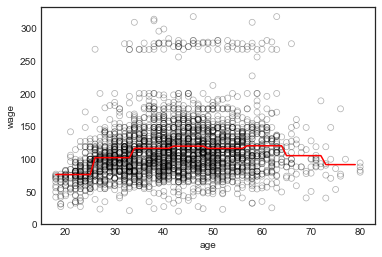

In [6]:
# Cut data into bins of age
df_cut, bins = pd.cut(df.age, bins=8, retbins=True, right=True)
    
# Get the step dataframes
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age', 'age_cut', 'wage'], axis=1)
    
# Transform step dataframe into dummies
df_steps_dummy = pd.get_dummies(df_steps['age_cut'])
df_steps_dummy.values.reshape(-1,1)

# Get age_grid
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Fit linear regression with 8 bins
bin_mapping = np.digitize(age_grid.ravel(), bins)
X_test = pd.get_dummies(bin_mapping)
regr = skl_lm.LinearRegression().fit(df_steps_dummy, df_steps.wage)
y_pred = regr.predict(X_test)

# Plot
sns.scatterplot(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(age_grid, y_pred, color='r')
plt.ylim(ymin=0)

## Question 7 - Other features

Wage data set contains some other features such as marital status(maritl), 
job class(jobclass), race (race). We will explore these features separatedly

#### Marital Status

Some simple plots shows that those who are married seems to get a slightly higher wage
than others. This is not surprising since most people are married which makes this 
variable very tricky to use!


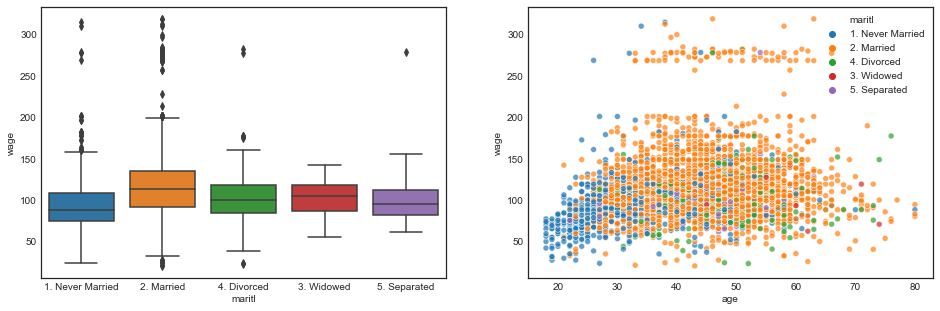

In [7]:
# Counted values
df.maritl.value_counts()

# Boxplot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))
sns.boxplot(df.maritl, df.wage, ax=ax1)
sns.scatterplot(df.age, df.wage, hue=df.maritl, ax=ax2, alpha=0.7)

First, I would like to do some naive regression using the categorial as the only
predictor.

Note that this is nothing more than an average prediction of each marital status. 

In [8]:
# Get dummy df
df_dummy = pd.get_dummies(df.maritl)
df_dummy.head()

# Regression on dummy
regr = sm.GLM(df.wage, df_dummy).fit()
regr.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
1. Never Married,92.7346,1.582,58.608,0.000,89.633,95.836
2. Married,118.8603,0.884,134.391,0.000,117.127,120.594
3. Widowed,99.5387,9.241,10.772,0.000,81.428,117.650
4. Divorced,103.1593,2.820,36.581,0.000,97.632,108.686
5. Separated,101.2158,5.431,18.636,0.000,90.571,111.861


Now lets try this with a age

#### Regression with age

In [9]:
# Polynomial with degree 4
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(df.age.values.reshape(-1,1))

# Polynomial with marital status dummmy
temp = pd.DataFrame(X_poly, columns=['intercept', 'x', 'x2', 'x3', 'x4'])
X_poly_dummy = pd.concat([temp, df_dummy], axis=1)

# Regression
regr = sm.GLM(df.wage, X_poly_dummy).fit()
regr.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,-108.6758,50.108,-2.169,0.030,-206.886,-10.465
x,16.7622,5.852,2.864,0.004,5.292,28.232
x2,-0.4462,0.204,-2.184,0.029,-0.847,-0.046
x3,0.0054,0.003,1.794,0.073,-0.001,0.011
x4,-2.609e-05,1.62e-05,-1.607,0.108,-5.79e-05,5.72e-06
1. Never Married,-22.3375,10.032,-2.227,0.026,-41.999,-2.676
2. Married,-8.4572,10.266,-0.824,0.410,-28.577,11.663
3. Widowed,-26.8858,12.751,-2.108,0.035,-51.878,-1.894
4. Divorced,-25.1746,10.426,-2.415,0.016,-45.610,-4.740
5. Separated,-25.8206,11.089,-2.328,0.020,-47.555,-4.086


Surprisingly, being married seems to be statistically insignificant in predicting wage
providing we also include 3 degree of age polynomial.

Running the same methods, we can see how jobclass affecting the wage. However, lets expand
on some new methods. Lets use GAM with age and job class as predictors

In [37]:
from pygam import LinearGAM,  f, l

# Get data
temp = df[['jobclass', 'age']]
temp['jobclass'] = temp['jobclass'].astype('category').cat.codes

# Run GAMS
gam = LinearGAM(f(0) + l(1))
gam.gridsearch(np.array(temp), np.array(df.wage))

d:\pycharmprojects\islr\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=f(0) + l(1) + intercept, 
   tol=0.0001, verbose=False)

<Figure size 432x288 with 0 Axes>

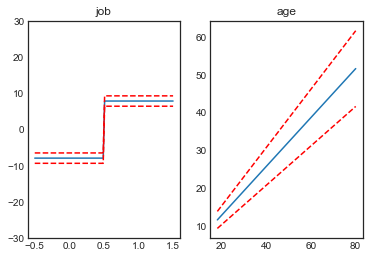

In [38]:
plt.figure()
fig, axs = plt.subplots(1,2)

titles = ['job', 'age']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])
    

Seems like Information work has a clear advantage over Industrial work when comparing 
wages. 